In [6]:
import numpy as np
import operator
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## Reading dataset  
[Dataset link](https://www.kaggle.com/arhamrumi/amazon-reviews-eda-20012018)  
The dataset we use has the following attributes: rating, verification status of the review, reviewer ID, product ID,date of review, and votes.  
However, for our analysis the relevant attributes are rating, reviewer ID, product ID.

In [7]:
sports = pd.read_csv("Sports_and_Outdoors.csv")
sports.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12969732 entries, 0 to 12969731
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   rating      int64 
 1   verified    bool  
 2   reviewerID  object
 3   product_id  object
 4   date        int64 
 5   vote        object
dtypes: bool(1), int64(2), object(3)
memory usage: 507.1+ MB


### Dropping columns not used for analysis
Dropping columns verified and vote as they are not useful for our analysis
&nbsp;

In [8]:
sports.drop(['verified', 'vote'], axis=1, inplace=True)
sports = sports.sort_values('date', ascending=False)
sports.head()


,rating,reviewerID,product_id,date
12968859,3,AAL07KPFE0VFI,B01HIT0QDG,1538697600
12969474,5,A39ANO7WWQ9PE8,B01HJA3STS,1538697600
12969475,5,A4HCTG3TV7UPM,B01HJA3STS,1538611200
12969105,1,A30DF0WFD9U1PT,B01HIY7NPU,1538611200
12965742,5,A2WCAIO2XACZ01,B01HGSLB6K,1538611200


In [9]:
products = sports['product_id'].unique()
users = sports['reviewerID'].unique()
print('Number of unique products', len(products))
print('Number of unique users', len(users))


Number of unique products 957764
Number of unique users 6703391


5    8342962
4    2046025
1     996049
3     967731
2     616965
Name: rating, dtype: int64

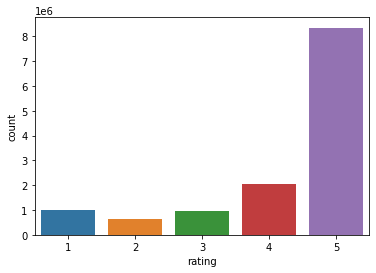

In [10]:
plot = sns.countplot(x='rating', data=sports)
sports['rating'].value_counts()


### Making a dictionary to store all ratings given by users to a particular product  


In [11]:
all_products = defaultdict(dict)
for ind in sports.itertuples():
    all_products[ind.product_id][ind.reviewerID] = ind.rating
all_products = dict(all_products)


### Top 30 products with most rating

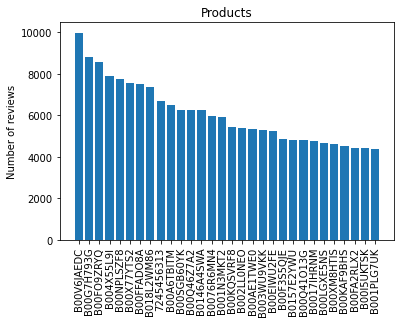

In [12]:
count_prods = []
for i, val in all_products.items():
    count_prods.append([len(val), i])
count_prods = sorted(count_prods, reverse=True)[:30]

number_of_reviews = [i[0] for i in count_prods]
prod_id = [i[1] for i in count_prods]
indexes = np.arange(len(number_of_reviews))

plt.bar(indexes, number_of_reviews)

plt.title('Products')
plt.xticks(indexes, prod_id, rotation='vertical')

plt.ylabel('Number of reviews')
plt.show()

### Removing all products for which only 1 rating has been given   


In [13]:
new_all = defaultdict(dict)
product_id_nottake = set()
for i, val in all_products.items():
    if len(val) > 1:
        new_all[i] = val.copy()
    else:
        product_id_nottake.add(i)
new_all = dict(new_all)
all_products = new_all


### Making a dictionary to store all ratings given to products by a particular user    
Note that the products which had only 1 rating will not be reflected in this dictionary  


In [14]:
all_users = defaultdict(dict)
for ind in sports.itertuples():
    if ind.product_id not in product_id_nottake:
        all_users[ind.reviewerID][ind.product_id] = ind.rating
all_users = dict(all_users)


### Top 30 users who rated most products

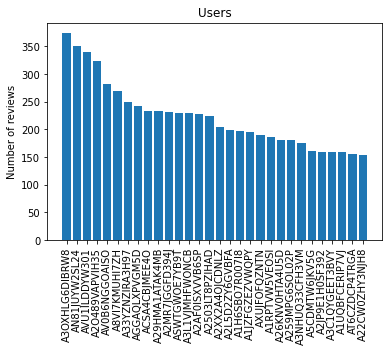

In [15]:
count_users = []
for i, val in all_users.items():
    count_users.append([len(val), i])
count_users = sorted(count_users, reverse=True)[:30]

number_of_reviews = [i[0] for i in count_users]
user_id = [i[1] for i in count_users]
indexes = np.arange(len(number_of_reviews))

plt.bar(indexes, number_of_reviews)

plt.title('Users')
plt.xticks(indexes, user_id, rotation='vertical')

plt.ylabel('Number of reviews')
plt.show()

&nbsp;
## Making the data centered around zero

> This is a preprocessing step which helps us in computing the **Pearson correlation**.   

$\Large r =\Large\frac{\Large\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\Large\sum\left(x_{i}-\bar{x}\right)^{2} \sum\left(y_{i}-\bar{y}\right)^{2}}}$  

$r = $ Correlation coefficient  
$ x_{i} = $	values of the x-variable in a sample  
$\bar{x} = $	mean of the values of the x-variable  
$ y_{i} = $	values of the y-variable in a sample  
$\bar{y} = $	mean of the values of the y-variable  

We assume that a value of zero is given to all the products for which ratings haven't been given by a particular user.Thus, the set of all ratings for a given user can now be considered as a vector.  
&nbsp;

In [16]:
normalized_products = defaultdict(dict)
for i, val in all_products.items():
    normalized_products[i] = val.copy()
for i, val in normalized_products.items():
    values = list(val.values())
    mean_val = np.mean(values)
    for j in val:
        val[j] -= mean_val

### For the each of the vectors defined in the previous step, we find the magnitudes.  


In [17]:
magnitudes = defaultdict(dict)

for i in normalized_products:
    values = list(normalized_products[i].values())
    magnitudes[i] = np.sqrt(np.sum(np.square(values)))


### Randomly selecting a user from the set of all users who have given atleast 20 ratings.  
If we select users who have lesser number of ratings, then we might get skewed results.  
To visualise the dataset, we need to filter out such exceptional cases in order to get proper predictions.


In [26]:
candidate_users = list()
for user, val in all_users.items():
    if len(val) >= 20:
        candidate_users.append(user)
sample_user = np.random.choice(candidate_users, size=1)[0]
print('The selected user id is', sample_user)


The selected user id is A2IA71EYO2ZWII


### Getting all the products which have more than 1 rating and have not been rated by the selected user.  


In [27]:
rest = list(set(all_products.keys()) - set(all_users[sample_user]))


### Choosing random 1000 products out of the list generated in the previous step  


In [28]:
random1000 = np.random.choice(rest, size=1000)


### Getting the list of all products for which ratings have been given by the sample user.  


In [29]:
compare_with = list(all_users[sample_user])


&nbsp;
## Getting predictions

For each of the products among the 1000 that we chose randomly, we try to predict the ratings which would have been given by the sample user. In order to acheive this, we find the similarity coefficient between the product whose rating is to be predicted, and all those products for which ratings have already been given by the sample user. Once we have the similarity coefficients, we predict the rating for that particular product using the formula :

$ \Large R(u, j) = \Large\frac{\Large\sum\limits_{i \ \epsilon \ compare \_ with} S_{ij} \ . \ R(u, i)}{\Large\sum S_{ij}} $ 
 
&nbsp;

In [30]:
prediction_dict = defaultdict(dict)

for item in random1000:
    sine, calc = dict(), []
    for rated in compare_with:
        if rated not in magnitudes:
            continue
        coeff = 0
        for user in normalized_products[item]:
            if user not in normalized_products[rated]:
                continue
            coeff += normalized_products[item][user] * normalized_products[rated][user]
        if magnitudes[rated] == 0 and magnitudes[item] == 0:
            sine[rated] = 1
        elif magnitudes[rated] == 0 or magnitudes[item] == 0:
            sine[rated] = 0
        else:
            sine[rated] = coeff / (magnitudes[rated] * magnitudes[item])

    coeffs = list()

    sorted_sine = dict(
        sorted(sine.items(), key=operator.itemgetter(1), reverse=True))
    maxrange = min(len(sorted_sine.values()), 15)
    for i in sorted_sine:
        if sorted_sine[i] <= 0:
            break
        calc.append(sorted_sine[i] * all_users[sample_user][i])
        coeffs.append(sorted_sine[i])
        maxrange -= 1
        if maxrange == 0:
            break
    if len(coeffs) == 0:
        continue
    prediction_dict[item] = sum(calc) / sum(coeffs)


#### Making a Data Frame having the products which the sample user has not rated yet, and the predicted rating value for the same.    


In [31]:
# now we will pick top 100 items to recommend to user
prediction_df = pd.DataFrame(prediction_dict.items(), columns=[
                             "product_id", "predicted_rating"])
prediction_df.head()

,product_id,predicted_rating
0,B00488R666,5.0
1,B00LGYHZT8,5.0
2,B0029F62LU,5.0
3,B00TY4AMYM,4.0
4,B0075D27WE,5.0


## Graphs for analysis

#### Line plot showing ratings predicted

<AxesSubplot:xlabel='rating', ylabel='frequency of rating'>

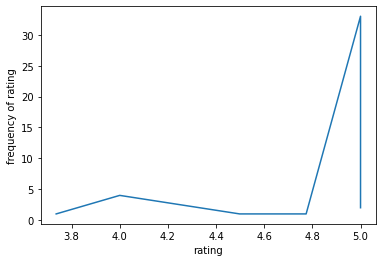

In [32]:
histogram = dict()
for i in prediction_df.itertuples():
    if histogram.get(i.predicted_rating) == None:
        histogram[i.predicted_rating] = 1
    else:
        histogram[i.predicted_rating] += 1
plot_data = pd.DataFrame(sorted(histogram.items()), columns=['rating', 'frequency of rating'])
sns.lineplot(x='rating', y='frequency of rating', data=plot_data)

# Top recommendations

In [33]:
results = prediction_df.sort_values(by="predicted_rating", ascending=False)
recommended_products = list()
for i in range(min(100 , len(results))):
    recommended_products.append(results.iloc[i]['product_id'])
print("Top " + str(len(recommended_products)) + " Recommended products for user " + str(sample_user) + " -")
for i in recommended_products:
    print(i)


Top 43 Recommended products for user A2IA71EYO2ZWII -
B0029F62LU
B002BMB8T2
B00488R666
B0036CN36W
B00K09P7UE
B00LLZCVYG
B000J084KY
B00TY25R0I
B001Q3LTV4
B00IAIG878
B01AUOHLI4
B013XJKTVO
B00BMAFOKS
B000F630II
B0001NDYOK
B00JZNQLU6
B001CK0MHI
B000EZ0ELQ
B00LGYHZT8
B002TI51QO
B00JTTWHTA
B00FEXSJTW
B0075D27WE
B000FY05PG
B001F17AZG
B0006ZK3KG
B00PZR1GBK
B017G7PXCY
B00B60HYQG
B001ZTVYLY
B009PCK91Y
B00FQDEOZI
B017XT23FK
B005KS1MJ0
B001QKK8UK
B002FXEWVI
B01DJW0E8S
B01GCJ6F2O
B000N8QM6K
B00BS54C9Q
B00TY4AMYM
B00KZD6ZH4
B000LC2348
